In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from __future__ import division
from scipy.special import erfinv

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv("../data/train.csv")

In [3]:
df_test = pd.read_csv("../data/test.csv" )

In [4]:
df_test.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
target = df_train["target"].values
ids_train = df_train["ID"].values
df_train = df_train.drop( [ "ID" , "target"] , axis = 1  )

In [6]:
ids_test = df_test["ID"].values 
df_test = df_test.drop( ["ID"] , axis = 1 )

In [67]:
cols_remove = []
for col in df_train.columns:
    
    if df_train[col].std() == 0:
        cols_remove.append( col )
        
df_train = df_train.drop( cols_remove , axis = 1 )
df_test = df_test.drop( cols_remove , axis = 1 )

In [70]:
df_test.shape

(49342, 4735)

In [75]:
cols_and_zeroes = []
for col in df_train.columns:
    no_of_zeroes = []
    cols_dict = {}
    aa = (df_train[col].value_counts())
    for key, value in aa.iteritems():
        if key==0:
            per = float(value * 100 / 4459)
            cols_dict[col] = float(per)
            cols_and_zeroes.append(cols_dict)

In [79]:
l= []
for i in cols_and_zeroes:
    for k,v in i.items():
        if v>=99:
            l.append(k)

In [80]:
len( l )

2108

In [81]:
df_train = df_train.drop( l , axis = 1 )
df_test = df_test.drop( l , axis = 1 )

In [82]:
df_train.shape

(4459, 2627)

In [84]:
df_test.shape

(49342, 2627)

In [85]:
def rank_gauss(x):
    # x is numpy vector
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2 # rank_x.max(), rank_x.min() should be in (-1, 1)
    efi_x = erfinv(rank_x) # np.sqrt(2)*erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

In [86]:
df_train = df_train.apply( rank_gauss )

In [87]:
df_test = df_test.apply( rank_gauss )

In [90]:
df_train.head()

,30347e683,20aa07010,dc5a8f1d8,11d86fa6a,4681de4fd,adf119b9a,b8a716ebf,d966ac62c,68b647452,0d866c3d7,...,8d8bffbae,9437d8b64,5831f4c76,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,7e293fbaf,9fc776466
0,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,...,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215,-2.609215
1,0.292764,0.680062,0.281971,0.275526,0.220560,0.617099,0.248279,0.289303,0.279390,0.259301,...,0.228084,0.249971,0.189466,0.283693,0.253782,0.271671,0.187406,0.274240,0.288007,0.274669
2,0.293197,0.144903,0.282401,0.275955,0.220977,0.610725,0.248702,0.289735,0.279820,0.259727,...,0.228503,0.250394,0.189878,0.284124,0.254206,0.272099,0.187818,0.274669,0.288439,0.275098
3,0.293630,0.144497,0.282832,0.276384,0.221395,0.604973,0.249124,0.290167,0.280250,0.260152,...,0.228922,0.250817,0.190290,0.284555,0.254630,0.272527,0.188230,0.275098,0.288871,0.275526
4,0.294063,0.636530,0.283262,0.276813,0.221812,0.586270,0.249547,0.290600,0.280680,0.260577,...,0.229341,0.251240,0.190702,0.284986,0.255055,0.272955,0.188642,0.275526,0.289303,0.275955


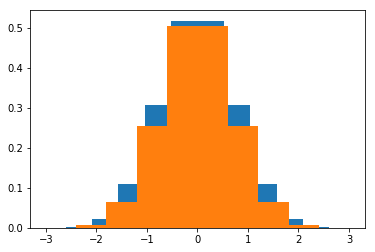

In [91]:
plt.hist (df_train["30347e683"] , normed = True  )
plt.hist( df_test["30347e683"] , normed = True )
plt.show()

In [93]:
df_train["30347e683"].mean()

0.0

In [95]:
df_train.shape

(4459, 2627)

In [96]:
df_train.to_csv("../data/train_norm.csv" , index = False )
df_test.to_csv("../data/test_norm.csv" , index = False )

In [97]:
pd.DataFrame( np.log( target ) ).to_csv("../data/labels_train.csv" , index = False )

In [98]:
X = df_train.values
X_test = df_test.values
labels_train = np.log( target.copy() ) 

In [44]:
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 10000
params = {"objective": "regression",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "metric":["l2"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }
NFOLDS = 5
kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=218)
final_cv_train = np.zeros(len(labels_train))
final_cv_pred = np.zeros(len( X_test))
x_score = []
for s in xrange(16):
    cv_train = np.zeros(len(labels_train))
    cv_pred = np.zeros(len(X_test))

    params['seed'] = s

    if True:
        kf = kfold.split( X ,   labels_train )

        best_trees = []
        fold_scores = []

        for i, (train_fold, validate) in enumerate(kf):
            X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
            dtrain = lgb.Dataset(X_train, label_train)
            dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
            
            
            bst = lgb.train(params, dtrain, num_boost_round, valid_sets=dvalid , verbose_eval=100,early_stopping_rounds=100)
            best_trees.append(bst.best_iteration)
            cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
            cv_train[validate] += bst.predict(X_validate)
            
            
            score = mean_squared_error( label_validate, cv_train[validate] )
            print( score )
            fold_scores.append(score)

        cv_pred /= NFOLDS
        final_cv_train += cv_train
        final_cv_pred += cv_pred

        print("cv score:")
        print mean_squared_error(labels_train, cv_train)
        print "current score:", mean_squared_error( labels_train , final_cv_train / (s + 1.)), s+1
        print(fold_scores)
        print(best_trees, np.mean(best_trees))

        x_score.append(mean_squared_error( labels_train , cv_train))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.32663
Early stopping, best iteration is:
[61]	valid_0's l2: 2.3036
2.3035975277069114
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.09292
Early stopping, best iteration is:
[53]	valid_0's l2: 2.06161
2.0616095843112396
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.13798
Early stopping, best iteration is:
[61]	valid_0's l2: 2.12385
2.1238478294343883
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.2149
Early stopping, best iteration is:
[44]	valid_0's l2: 2.17284
2.172843054656511
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.26308
Early stopping, best iteration is:
[70]	valid_0's l2: 2.25698
2.2569814162918522
cv score:
2.183759465002313
current score: 2.183759465002313 1
[2.3035975277069114, 2.0616095843112396, 2.1238478294343883, 2.172843054656511, 

2.2347116341164566
cv score:
2.1818708580345993
current score: 2.1615420097888416 8
[2.286872317505452, 2.076098738004669, 2.1396055076264644, 2.1721253314581603, 2.2347116341164566]
([63, 65, 69, 45, 59], 60.2)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.31459
Early stopping, best iteration is:
[64]	valid_0's l2: 2.27848
2.2784839255201423
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.11734
Early stopping, best iteration is:
[70]	valid_0's l2: 2.08842
2.0884164543015604
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.16911
Early stopping, best iteration is:
[59]	valid_0's l2: 2.14218
2.142175373275374
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.21319
Early stopping, best iteration is:
[56]	valid_0's l2: 2.17171
2.171714220276383
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.2771
Early stoppi

2.1688920573131703
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.27233
Early stopping, best iteration is:
[52]	valid_0's l2: 2.26941
2.2694136552149695
cv score:
2.1946261910163107
current score: 2.1608296298223375 16
[2.305967771774146, 2.0948080817864616, 2.1341332314414596, 2.1688920573131703, 2.2694136552149695]
([54, 84, 77, 52, 52], 63.8)


In [45]:
preds = final_cv_pred / 16.0
pd.DataFrame({'ID': ids_test, 'target': preds }).to_csv('../data/lgbm3_pred_avg.csv', index=False)

In [14]:
pres_nn = pd.read_csv("../data/preds1.csv" )

In [15]:
pres_nn.head()

,Unnamed: 0,index,preds
0,0,0,15.620798
1,1,1,14.920779
2,2,2,15.185871
3,3,3,14.937533
4,4,4,15.172850


In [16]:
pd.DataFrame({'ID': ids_test, 'target':   np.exp( pres_nn["preds"] )   }).to_csv('../data/lgbm3_pred_nn_elu-4k-norm.csv', index=False)